# Decision_Tree

In [1]:
import pandas as pd
from math import log
from sklearn.externals.six import StringIO
from sklearn import metrics
from IPython.display import Image
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

In [2]:
def splitDataSet(data, key, fea_value):
    retDataSet = data[data[key]==fea_value]
    return retDataSet

def calcShannonEnt(data):
    label_size = data.groupby('label').size().reset_index(name='Size')
    numEntires = data.shape[0]
    shannonEnt = 0.0
    for key in label_size['label'].tolist():
        prob = float(label_size[label_size['label']==key].values[0][1]) / numEntires
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

def chooseBestFeatureToSplit(data):
    data_XY = data
    X_data = data.drop('label',axis=1)
    baseEntropy = calcShannonEnt(data_XY)
    bestInfoGain = 0.0
    bestFeature = -1
    columns_list = X_data.columns.tolist()
    for key in columns_list:
        newEntropy = 0.0
        fea_size = X_data.groupby(key).size().reset_index(name='Size')
        fea_value_list = fea_size[key].tolist()
        for fea_value in fea_value_list:
            subDataSet = splitDataSet(data_XY, key, fea_value)
            prob = subDataSet.shape[0] / float(data_XY.shape[0])
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
        if (infoGain >= bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = key
    return bestFeature

def majorityCnt(data):
    temp = data.groupby('label').size().reset_index(name='Size')
    maxCountClass = temp[temp['Size']==temp['Size'].max()].values[0][0]
    return maxCountClass

def createTree(data_XY, featLabels):
    data = data_XY
    if data.shape[1]==2 or data.groupby('label').size().reset_index(name='Size').values[0][1] == data.shape[0]:
        return majorityCnt(data)
    bestFeat = chooseBestFeatureToSplit(data)
    featLabels.append(bestFeat)
    myTree = {bestFeat:{}}
    featValues = data.groupby(bestFeat).size().reset_index(name='Size')[bestFeat].tolist()
    for value in featValues:
        myTree[bestFeat][value] = createTree(splitDataSet(data, bestFeat, value).drop(bestFeat,axis=1), featLabels)
    return myTree

def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = next(iter(myTree))
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = next(iter(myTree))
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    arrow_args = dict(arrowstyle="<-")
    font = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc", size=14)
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args, FontProperties=font)

def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):
    decisionNode = dict(boxstyle="sawtooth", fc="0.8")
    leafNode = dict(boxstyle="round4", fc="0.8")
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = next(iter(myTree))
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

def classify(inputTree, featLabels, testVec):
    firstStr = next(iter(inputTree))
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else: classLabel = secondDict[key]
    return classLabel

准确率：  0.9909726775956283


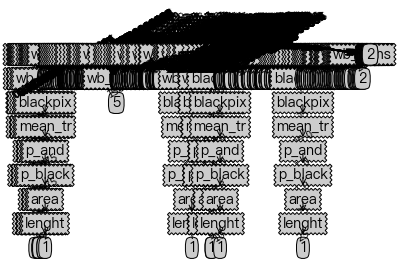

In [3]:
if __name__ == '__main__':
    data = pd.read_fwf('./第2次作业/Page_Blocks_Classification_Data_Set/page-blocks.data',header=None)
    data.columns=["height","lenght","area","eccen","p_black","p_and","mean_tr","blackpix","blackand","wb_trans","label"]  #加载数据
    '''
    Y = data.pop('label')
    Y = pd.DataFrame(Y)
    X = data
    '''
    featLabels = []
    myTree = createTree(data, featLabels)
    #testVec = [6,18,108,3.0,0.287,0.741,4.43,31,80,7]
    #result = classify(myTree, featLabels, testVec)
    data_pre = data.sample(n=100)
    data_pre = data_pre.reset_index(drop=True)
    X_pre = data_pre.drop('label',axis=1)
    Y_true = data_pre['label']
    X_list = X_pre.values
    Y_pre = []
    fea_list = ["height","lenght","area","eccen","p_black","p_and","mean_tr","blackpix","blackand","wb_trans"]
    for testVec in X_list:
        Y_pre.append(classify(myTree, fea_list, testVec))
    Y_pre = pd.Series(Y_pre)
    print('准确率： ',metrics.f1_score(Y_true, Y_pre, average='weighted'))
    pre_res = pd.concat([Y_pre,Y_true],axis=1)
    pre_res.columns = ['Pre', 'True']
    createPlot(myTree)

In [4]:
print(pre_res)

    Pre  True
0     1     1
1     1     1
2     1     1
3     1     1
4     1     1
5     1     1
6     1     1
7     1     1
8     1     1
9     1     1
10    1     1
11    1     1
12    1     1
13    1     1
14    1     1
15    1     1
16    1     1
17    1     1
18    1     1
19    1     1
20    1     1
21    1     1
22    1     1
23    1     1
24    5     5
25    1     1
26    1     1
27    1     1
28    1     1
29    1     1
..  ...   ...
70    1     1
71    1     1
72    1     1
73    1     1
74    1     1
75    4     4
76    1     1
77    5     5
78    1     1
79    1     1
80    1     1
81    1     1
82    1     1
83    1     1
84    1     1
85    1     1
86    1     1
87    1     1
88    1     1
89    1     1
90    1     1
91    1     1
92    2     2
93    1     1
94    1     1
95    1     1
96    1     1
97    1     1
98    1     1
99    1     1

[100 rows x 2 columns]


# KNN

In [10]:
import pandas as pd
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import sklearn

In [11]:
data = pd.read_csv('./第2次作业/letter_Recognition_Datasets/letter-recognition.data',header=None)
data.columns = ['lettr','x-box','y-box','width','high','onpix','x-bar','y-bar','x2bar','y2bar','xybar','x2ybr','xy2br','x-ege','xegvy','y-ege','yegvx']
le = LabelEncoder()
data['lettr'] = le.fit_transform(data['lettr'])
data_pre = data.sample(n=100)

In [12]:
Y = data.pop('lettr')
X = data
Y_true = data_pre.pop('lettr')
X_pre = data_pre

In [13]:
knn = neighbors.KNeighborsClassifier()
knn.fit(X, Y)
Y_pre = knn.predict(X_pre)

In [14]:
Y_pre = pd.Series(Y_pre)
Y_true = Y_true.reset_index(drop=True)
pre_res = pd.concat([Y_pre,Y_true],axis=1)
pre_res.columns = ['Pre', 'True']
print('准确率： ',metrics.f1_score(Y_true, Y_pre, average='weighted'))
pre_res

准确率：  0.9806153846153847


,Pre,True
0,17,17
1,1,1
2,7,7
3,22,22
4,15,15
5,0,0
6,21,21
7,3,3
8,21,21
9,25,25
